In [1]:
#Importing all the libraries to be used
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score

In [2]:
data = pd.read_csv('spam.csv',encoding='latin-1')
data.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
data = data.iloc[:,:2]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.rename(columns={'v1':'label', 'v2':'message'},inplace=True)

In [6]:
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
data.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [9]:
data.isnull().sum()

label      0
message    0
dtype: int64

In [10]:
blanks = []  # start with an empty list

for i,lb,ms in data.itertuples():  # iterate over the DataFrame
    if type(ms)==str:            # avoid NaN values
        if ms.isspace():         # test 'message' for only whitespace
            blanks.append(i)     # add matching index numbers to the list
        
print(len(blanks))

0


<AxesSubplot:xlabel='label', ylabel='count'>

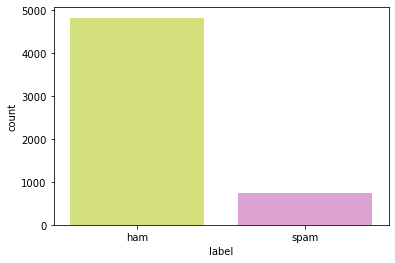

In [11]:
cols= ["#E1F16B", "#E598D8"] 
sns.countplot(data['label'],palette=cols)

In [12]:
data["No_of_Characters"] = data["message"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row['message']), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row['message']), axis=1).apply(len)


In [15]:
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/terminator/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
data.head()

,label,message,No_of_Characters,No_of_Words,No_of_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


<Figure size 1800x1440 with 0 Axes>

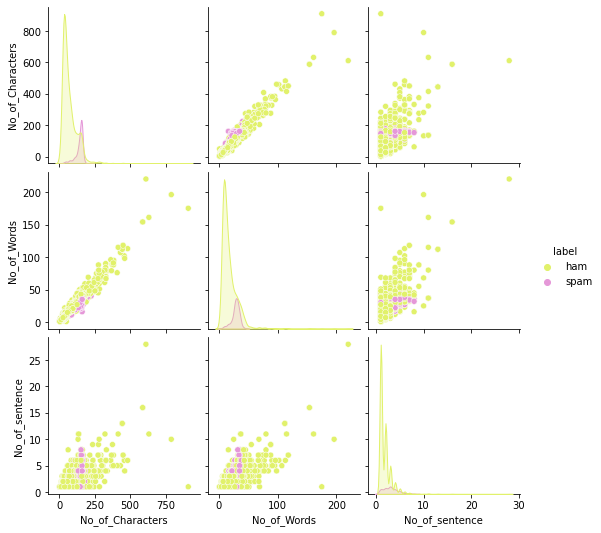

In [ ]:
plt.figure(figsize=(25,20))
f = sns.pairplot(data=data,hue='label',palette=cols)
plt.show(f)

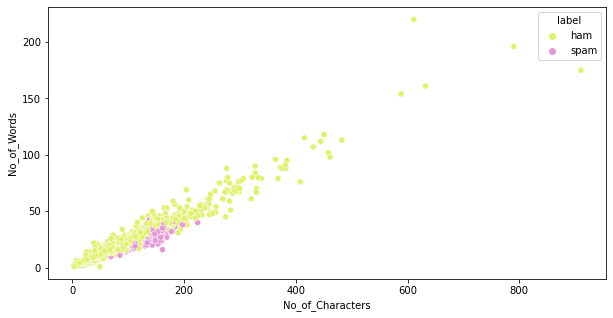

In [ ]:
plt.figure(figsize=(10,5))
f =sns.scatterplot(x='No_of_Characters',y='No_of_Words',data=data,hue='label',palette=cols)
plt.show(f)

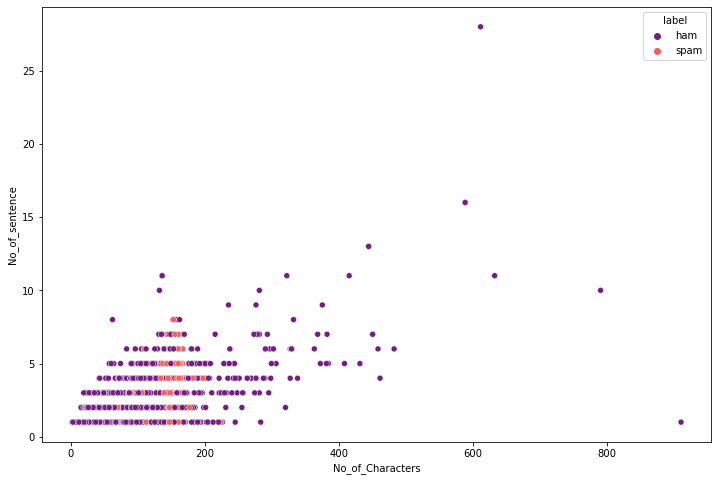

In [ ]:
plt.figure(figsize=(12,8))
f =sns.scatterplot(x='No_of_Characters',y='No_of_sentence',data=data,hue='label',palette='magma')
plt.show(f)

In [ ]:
#Dropping the outliers. 
data = data[(data["No_of_Characters"]<400)]
data.shape

(5555, 5)

<Figure size 1080x720 with 0 Axes>

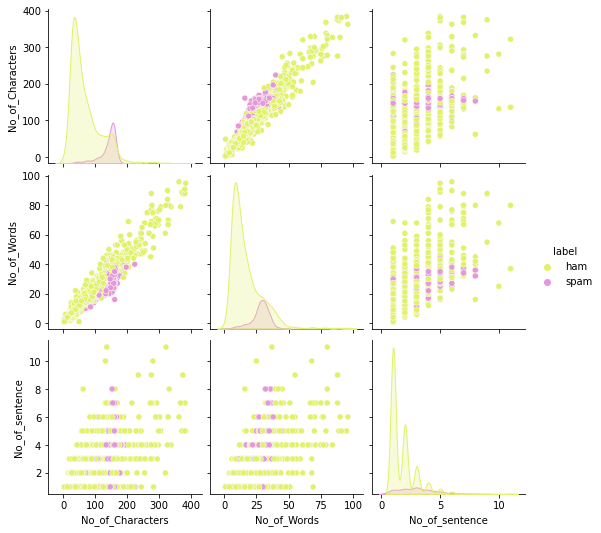

In [ ]:
plt.figure(figsize=(15,10))
f = sns.pairplot(data=data,hue='label',palette=cols)
plt.show(f)

In [13]:
def clean_words(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["message"].apply(clean_words)
print(*data["Clean_Text"][:5], sep = "\n")

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [14]:
data['Tokenize_word'] = data.apply(lambda row: nltk.word_tokenize(row['message']),axis=1)

In [29]:
data.head(1)

,label,message,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_word,NoStop_word,lematize_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go until jurong point crazy available only in ...,"[Go, until, jurong, point, ,, crazy, .., Avail...","[Go, jurong, point, ,, crazy, .., Available, b...","[Go, jurong, point, ,, crazy, .., Available, b..."


In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/terminator/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return [word for word in text if word not in stop_words]

data['NoStop_word'] = data['Tokenize_word'].apply(remove_stopwords)

In [20]:
lemmaztizer = WordNetLemmatizer()
def lematize_word(text):
    return [lemmaztizer.lemmatize(word,pos='v') for word in text]

data['lematize_text'] = data['NoStop_word'].apply(lematize_word)

In [19]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/terminator/nltk_data...


True

In [21]:
message= []
for i in data["lematize_text"]:
    msg = ' '.join([row for row in i])
    message.append(msg)

In [22]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(message)

In [23]:
X.shape

(5572, 7936)

In [28]:
y=LabelEncoder().fit_transform(data['label'])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
classifiers = [MultinomialNB(), 
               RandomForestClassifier(n_estimators=300),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [31]:
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.958850 
RandomForest: 0.975052 
KNeighbours: 0.894031 
SVC: 0.971194 


In [32]:
sks = StratifiedKFold(n_splits=5)
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=sks)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.953705 
RandomForest: 0.973766 
KNeighbours: 0.899699 
SVC: 0.970679 


In [33]:
precision =[]
recall =[]
accur_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = precision_score(y_test, pred_test)
    recal = recall_score(y_test, pred_test)
    accur = accuracy_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    accur_score.append(accur)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [34]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'Accuracy Score':accur_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [35]:
Results.head()

,Precision,Recall,Accuracy Score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.0,0.757009,0.968806,0.977804,0.9982
RandomForest,1.0,0.845794,0.980204,0.977804,0.9982
KNeighbours,1.0,0.275701,0.907019,0.977804,0.9982
SVC,1.0,0.827103,0.977804,0.977804,0.9982
